<p align="center">
    <a href="https://predict-idlab.github.io/landmarker">
        <img alt="landmarker" src="https://raw.githubusercontent.com/predict-idlab/landmarker/main/docs/_static/images/logo.svg" width="66%">
    </a>
</p>

# Training and Evaluating Static Heatmap Regression Model for Multi-Instance and Multi-Class Landmark Detetection (EndoVis 2015 Challenge)

In this tutorial, we will train and evaluate an direct static heatmap regression model for landmark 
detection with EndoVis 2015 Challenge. We will use part of the EndoVis 2015 challenge dataset to 
construct a multi-instance and multi-class landmark detection task. The dataset contains 4 training 
and 6 testing videos of robotic surgery. The goal is to predict the location of instruments in the video, 
more specifically the tip of the clasper. We only consider the clasper points and ignore the other points,
since they are way more ambiguous. One of the difficulties 

The videos are transformed into images and the annotations are 
given as 2D points. The dataset is split into a training and testing set. The training set contains 4 videos and 
the testing set contains 6 videos, such as specified in the challenge. 

We will go through the following steps:
* [Loading the dataset](#Loading-the-dataset)
* [Inspecting the dataset](#Inspecting-the-dataset)
* [Training and initializing the UNet model](#Training-the-model)
* [Evaluating the model](#Evaluating-the-model)

<a target="_blank" href="https://colab.research.google.com/github/predict-idlab/landmarker/examples/static_unet_endovis2015.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Setup environment

In [1]:
# !python -c "import landmarker" || pip install landmarker

import sys
import os

sys.path.append("../src/")

## Setup imports and variables

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from monai.transforms import (Compose, RandAffined, RandGaussianNoised, ScaleIntensityd,
                              RandScaleIntensityd, RandAdjustContrastd, RandHistogramShiftd,
                              RandFlipd
)
from tqdm.notebook import tqdm

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Loading the dataset

In [4]:
fn_keys = ('image', 'mask')
spatial_transformd = [RandAffined(fn_keys, prob=1,
                        rotate_range=(-np.pi, np.pi),
                        scale_range=(-0.1, 0.1),
                        shear_range=(-0.1, 0.1),
                        padding_mode="zeros"
                        ),
                     ]

train_transformd = Compose([
                            RandGaussianNoised(('image', ), prob=0.2, mean=0, std=0.1),  # Add gaussian noise
                            RandScaleIntensityd(('image', ), factors=0.25, prob=0.2),  # Add random intensity scaling
                            RandAdjustContrastd(('image', ), prob=0.2, gamma=(0.5,4.5)),  # Randomly adjust contrast
                            RandHistogramShiftd(('image', ), prob=0.2),  # Randomly shift histogram
                            ScaleIntensityd(('image', )),  # Scale intensity
                        ] + spatial_transformd)


inference_transformd = Compose([
    ScaleIntensityd(('image', )),
])

In [5]:
from landmarker.datasets import get_endovis2015_heatmap_datasets

data_dir = "../../data"
ds_train, ds_test = get_endovis2015_heatmap_datasets(data_dir, train_transform = train_transformd,
                                                     inference_transform= inference_transformd,
                                                     dim_img = (512, 512), sigma=10,
                                                     class_names=["LeftClasperPoint", 
                                                                  "RightClasperPoint",
                                                                  "HeadPoint",
                                                                  "ShaftPoint",
                                                                  "EndPoint"])

Reading 940 images...


100%|██████████| 940/940 [01:18<00:00, 12.02it/s]


Resizing 940 images and landmarks...


100%|██████████| 940/940 [00:17<00:00, 52.88it/s]


Creating heatmaps for 940 images... (batch size: 32)


100%|██████████| 29/29 [04:52<00:00, 10.10s/it]


Reading 910 images...


100%|██████████| 910/910 [00:52<00:00, 17.25it/s]


Resizing 910 images and landmarks...


100%|██████████| 910/910 [00:17<00:00, 53.53it/s]


Creating heatmaps for 910 images... (batch size: 32)


100%|██████████| 28/28 [04:36<00:00,  9.86s/it]


## Inspecting the dataset

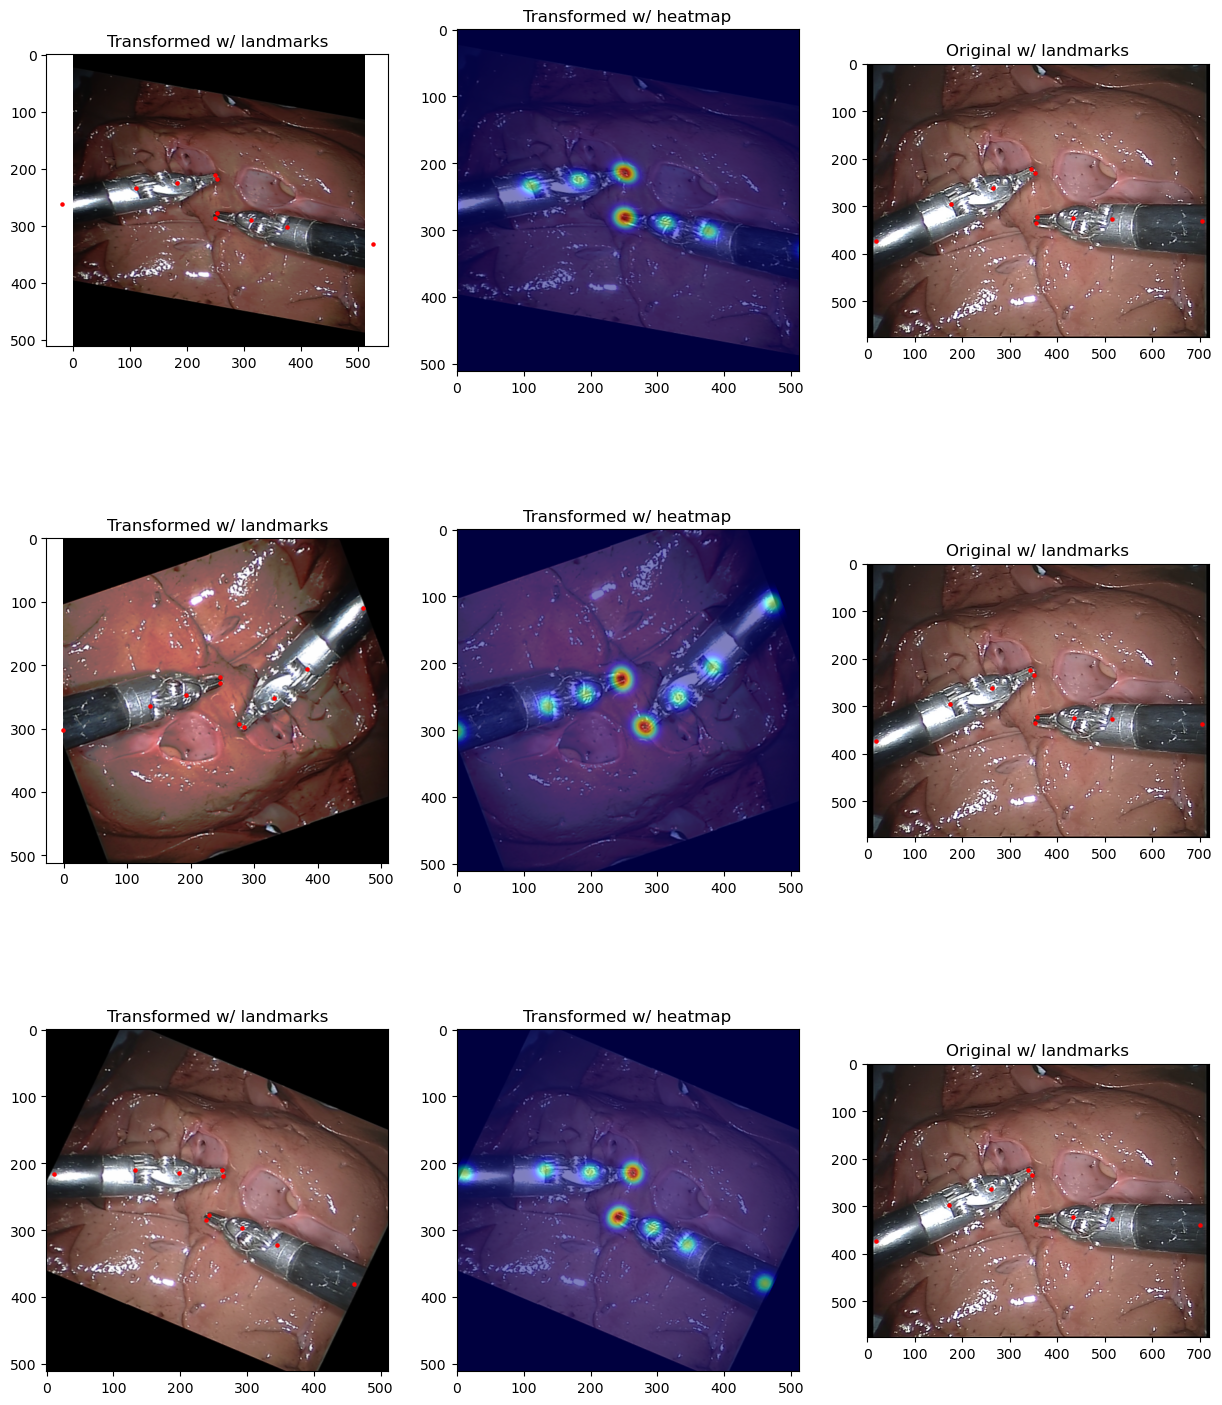

In [6]:
from landmarker.visualize import inspection_plot

# Plot the first 3 images from the training set
# inspection_plot(ds_train, np.random.randint(0, len(ds_train), 3))
inspection_plot(ds_train, range(3))

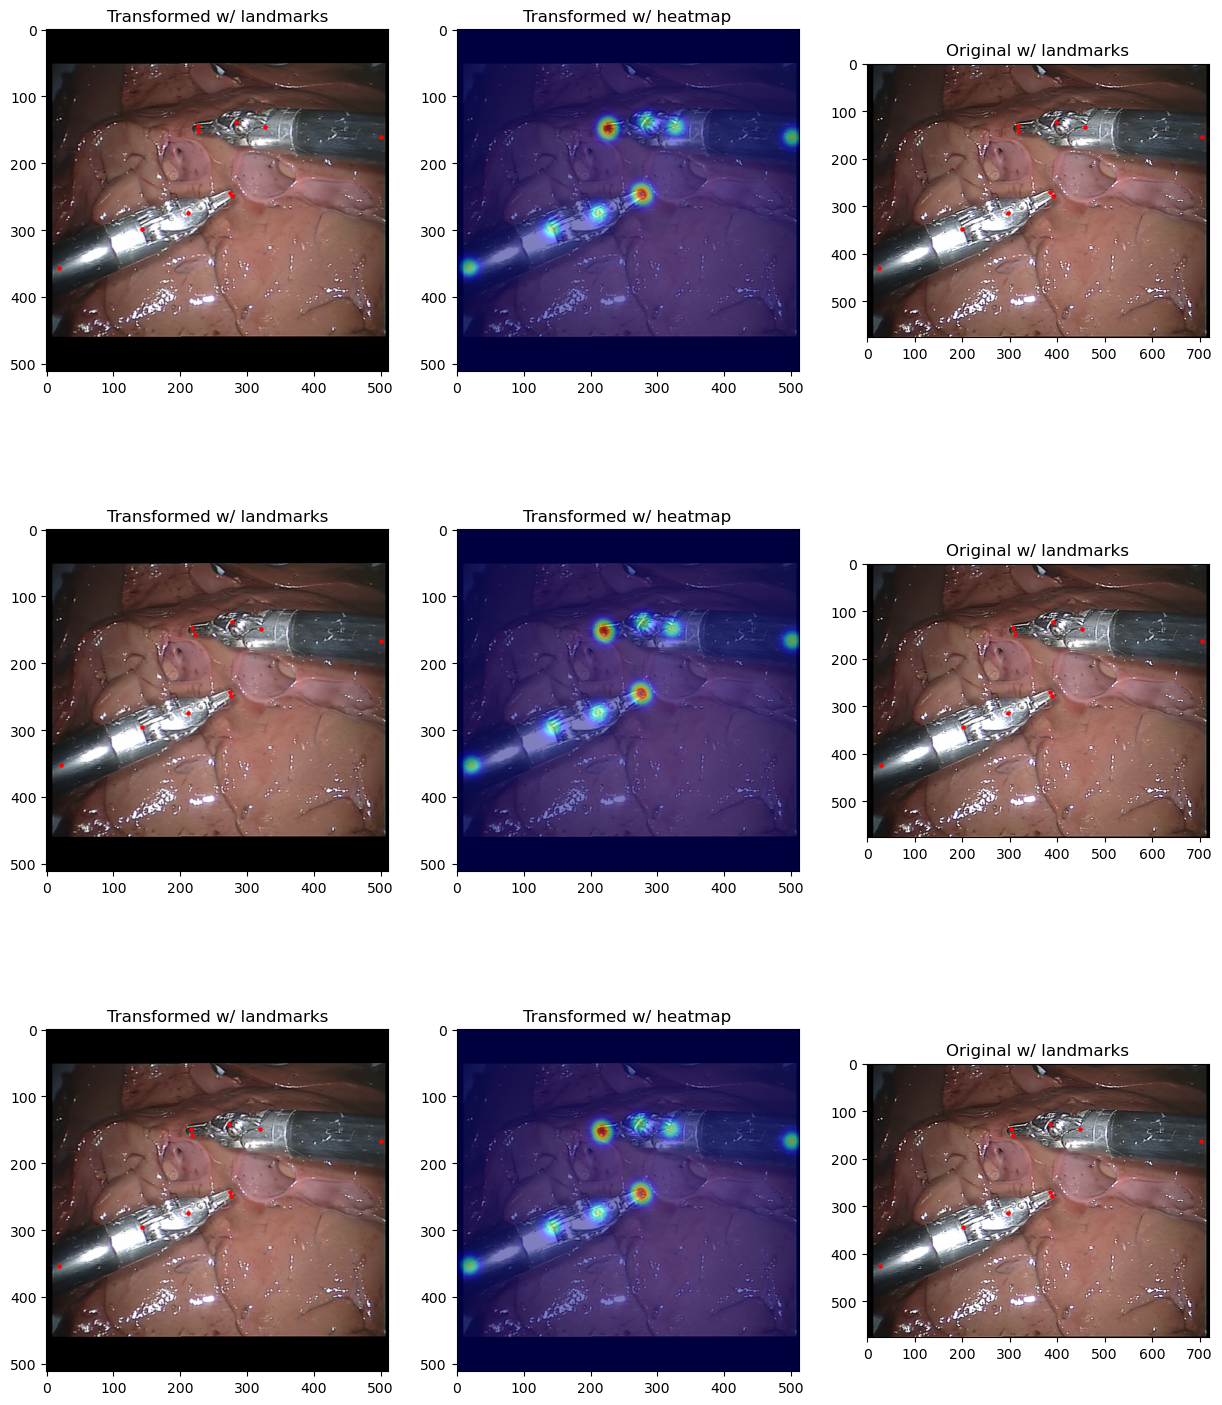

In [7]:
# Plot the first 3 images from the test1 set
inspection_plot(ds_test, range(3))

## Training and initializing the SpatialConfiguration model

### Initializing the model, optimizer and loss function

In [8]:
from torch import nn
import segmentation_models_pytorch as smp

model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights="imagenet",
        in_channels=3,
        classes=5,
        decoder_channels=(256, 128, 64, 32, 32),
).to(device)

lr = 5e-4
batch_size = 16
epochs = 40

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)

criterion = nn.BCEWithLogitsLoss()

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1,)

### Setting the data loaders and split training set

In [9]:
split_lengths = [0.8, 0.2]
train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=5)
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=5)

### Training the model

In [10]:
from landmarker.heatmap.decoder import heatmap_to_coord, heatmap_to_multiple_coord
from landmarker.metrics import point_error

from torch.nn.functional import sigmoid

from landmarker.metrics.metrics import multi_instance_point_error

def train_epoch(model, train_loader, criterion, optimizer, device):
    running_loss = 0
    model.train()
    for i, batch in enumerate(tqdm(train_loader)):
        images = batch["image"].to(device)
        heatmaps = batch["mask"].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, heatmaps)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def val_epoch(model, val_loader, criterion, device):
    eval_loss = 0
    model.eval()
    with torch.no_grad():
        for _, batch in enumerate(tqdm(val_loader)):
            images = batch["image"].to(device)
            heatmaps = batch["mask"].to(device)
            landmarks = batch["landmark"].to(device)
            outputs = model(images)
            loss = criterion(outputs, heatmaps)
            eval_loss += loss.item()
    return eval_loss / len(val_loader)

def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=1000):
    for epoch in tqdm(range(epochs)):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        train_transform = ds_train.transform
        ds_train.transform = None
        val_loss = val_epoch(model, val_loader, criterion, device)
        ds_train.transform = train_transform
        lr_scheduler.step()
        print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.8f} - Val loss: {val_loss:.8f} - lr: {lr_scheduler.get_last_lr():}")

In [ ]:
train(model, train_loader, test_loader, criterion, optimizer, device,
      epochs=epochs)

## Evaluating the model

In [11]:
# torch.save(model.state_dict(), "endovis2015-sigma10.pt")
# model.load_state_dict(torch.load("endovis2015-sigma10.pt", weights_only=True))

<All keys matched successfully>

In [12]:
from landmarker.heatmap.decoder import heatmap_to_coord, heatmap_to_multiple_coord

pred_landmarks = []
true_landmarks = []
dim_origs = []
pixel_spacings = []
paddings = []
tp = []
fp = []
fn = []
test_mpe = torch.zeros(ds_test.landmarks.shape[:2])
test_tp = torch.zeros(ds_test.landmarks.shape[:2])
test_fp = torch.zeros(ds_test.landmarks.shape[:2])
test_fn = torch.zeros(ds_test.landmarks.shape[:2])
model.to(device)
model.eval()
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader)):
        images = batch["image"]
        heatmaps = batch["mask"]
        landmarks = batch["landmark"]
        outputs = sigmoid(model(images.to(device)).detach().cpu())
        offset_coords = outputs.shape[1]-landmarks.shape[1]
        pred_landmarks_list, _ = heatmap_to_multiple_coord(outputs, window=17,
                                                           threshold=0.5,
                                                           method="argmax")
        pe_batch, tp_batch, fp_batch, fn_batch, pred_landmarks_torch = multi_instance_point_error(
            true_landmarks=landmarks, pred_landmarks=pred_landmarks_list, dim=(512, 512),
            dim_orig=batch["dim_original"], pixel_spacing=batch["spacing"],
            padding=batch["padding"], reduction="none")
        test_mpe[i*batch_size:(i*batch_size + landmarks.shape[0])] = pe_batch
        test_tp[i*batch_size:(i*batch_size + landmarks.shape[0])] = tp_batch
        test_fp[i*batch_size:(i*batch_size + landmarks.shape[0])] = fp_batch
        test_fn[i*batch_size:(i*batch_size + landmarks.shape[0])] = fn_batch
        pred_landmarks.append(pred_landmarks_torch)
        true_landmarks.append(landmarks)
        dim_origs.append(batch["dim_original"])
        pixel_spacings.append(batch["spacing"])
        paddings.append(batch["padding"])
        tp.append(tp_batch)
        fp.append(fp_batch)
        fn.append(fn_batch)


print(f"Test Mean PE: {test_mpe.nanmean():.4f}")
print(f"Test TP: {test_tp.sum():.4f}")
print(f"Test FP: {test_fp.sum():.4f}")
print(f"Test FN: {test_fn.sum():.4f}")

  0%|          | 0/57 [00:00<?, ?it/s]

Test Mean PE: 8.2540
Test TP: 6843.0000
Test FP: 88.0000
Test FN: 2257.0000


In [13]:
from landmarker.metrics import sdr

sdr_test = sdr([4, 5, 10, 20], true_landmarks=torch.cat(true_landmarks, axis=0), pred_landmarks=torch.cat(pred_landmarks, axis=0),
               dim=(512, 512), dim_orig=torch.cat(dim_origs, axis=0).int(), pixel_spacing=torch.cat(pixel_spacings, axis=0),
               padding=torch.cat(paddings, axis=0))
for key in sdr_test:
    print(f"SDR for {key}mm: {sdr_test[key]:.4f}")

SDR for 4mm: 22.5055
SDR for 5mm: 31.0549
SDR for 10mm: 58.1209
SDR for 20mm: 69.5055


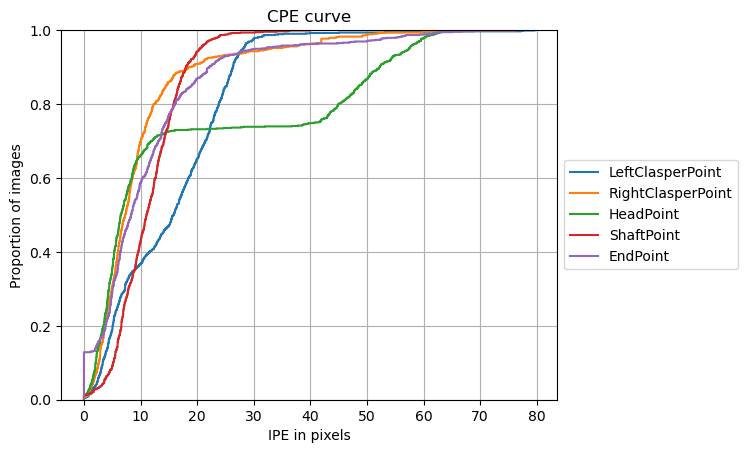

In [14]:
from landmarker.visualize import plot_cpe

plot_cpe(torch.cat(true_landmarks, axis=0), torch.cat(pred_landmarks, axis=0), dim=(512, 512),
            dim_orig=torch.cat(dim_origs, axis=0).int(), pixel_spacing=torch.cat(pixel_spacings, axis=0),
            padding=torch.cat(paddings, axis=0), class_names=ds_test.class_names,
            group=False, title="CPE curve", save_path=None,
            stat='proportion', unit='pixels', kind='ecdf')

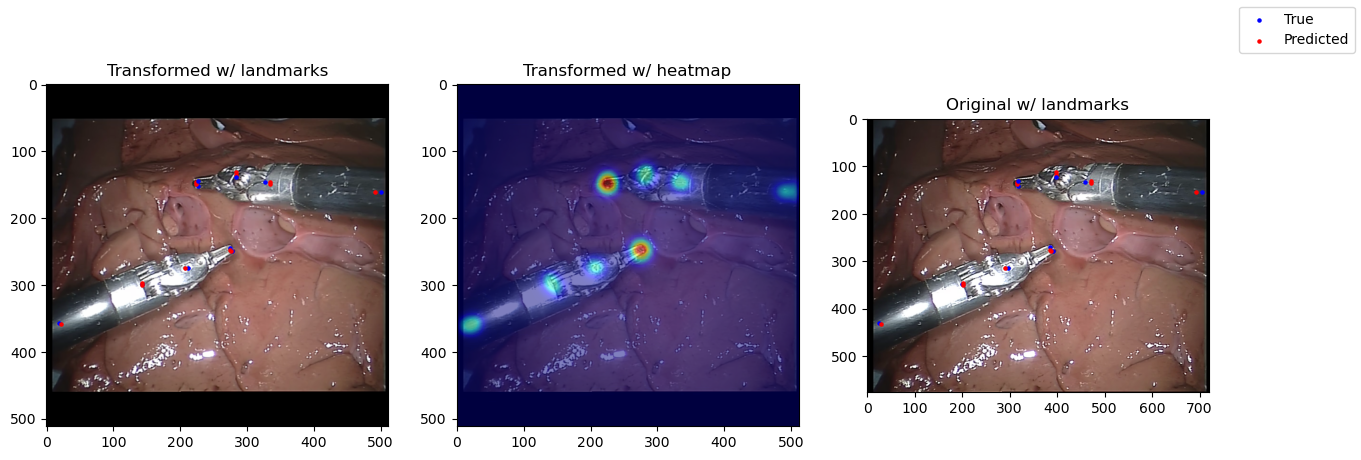

In [18]:
from landmarker.visualize.utils import prediction_inspect_plot_multi_instance
from torch.nn.functional import sigmoid

model.eval()
model.to("cpu")
prediction_inspect_plot_multi_instance(ds_test, model, 0, activation=sigmoid, save_path="pred_inspect_plot_endovis.pdf", fig_title="")

In [17]:
from landmarker.visualize.evaluation import multi_instance_detection_report

multi_instance_detection_report(torch.cat(true_landmarks, axis=0), torch.cat(pred_landmarks, axis=0),
                                torch.cat(tp, axis=0), torch.cat(fp, axis=0), torch.cat(fn, axis=0), dim=(512, 512),
                                dim_orig=torch.cat(dim_origs, axis=0).int(), pixel_spacing=torch.cat(pixel_spacings, axis=0),
                                padding=torch.cat(paddings, axis=0), class_names=ds_test.class_names)

Detection report:
1# Instance detection statistics:
Class               TP        FP        FN        TPR       
------------------------------------------------------------
LeftClasperPoint    1497.0    37.0      323.0     0.82      
RightClasperPoint   1502.0    44.0      318.0     0.83      
HeadPoint           1185.0    0.0       635.0     0.65      
ShaftPoint          1562.0    7.0       258.0     0.86      
EndPoint            1097.0    0.0       723.0     0.60      

2# Point-to-point error (PE) statistics:
Class               Mean      Median    Std       Min       Max       
----------------------------------------------------------------------
LeftClasperPoint    9.21      6.81      7.37      0.10      79.67     
RightClasperPoint   6.01      4.13      7.40      0.20      61.69     
HeadPoint           13.39     5.69      16.60     0.30      56.57     
ShaftPoint          6.65      6.29      3.73      0.11      28.89     
EndPoint            9.32      6.79      9.21      0.3